<a href="https://colab.research.google.com/github/synchronizeteam/channa_classification/blob/model_aldy/Ikan_Channa_VGG16_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import io

from google.colab import drive
from torchvision import transforms
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from google.colab import files
from PIL import Image
import os

%matplotlib inline

torch.manual_seed(123)

In [ ]:
#Pastiin pake GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Definisi Kelas
class_names = ['andrao', 'asiatica', 'auranti', 'barca', 'maru', 'stewartii']

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    # transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor()
])

In [ ]:
# Set input and output directories
# input_dir = '/content/drive/MyDrive/datasheet'
# output_dir = '/content/drive/MyDrive/datasheet_jpg'

In [ ]:
# # Loop through all image files in the input directory
# for filename in os.listdir(input_dir):
#     if filename.endswith('.png') or filename.endswith('.jpg'):
#         # Open the image file
#         img_path = os.path.join(input_dir, filename)
#         img = Image.open(img_path)

#         # Create output filename by replacing extension with .jpg
#         output_filename = os.path.splitext(filename)[0] + '.jpg'
#         output_path = os.path.join(output_dir, output_filename)

#         # Convert the image to JPEG format and save to output file
#         img.save(output_path, 'JPEG')

In [ ]:
# Download Datasheet
# !wget 'https://drive.google.com/drive/folders/18-8on0Sl-80moOOAGV9GJXYdMFctoFxx?usp=share_link'

In [ ]:
#apply pada dataset yg dipakai
dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/datasheet', transform=transform)

In [ ]:
#split data train dan val, buat loader
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_set, val_set = random_split(dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size)

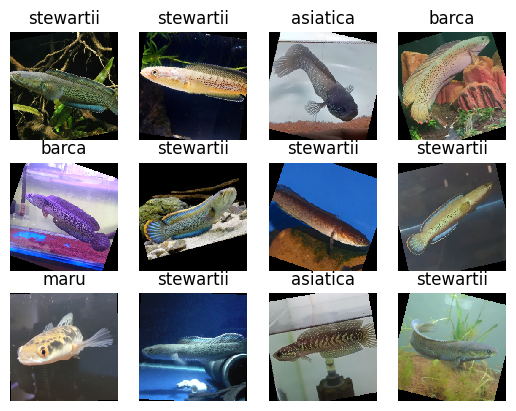

In [ ]:
#cek gambar data
images, labels = next(iter(train_loader))

fig = plt.figure()
#plot gambar
for i in range(12):
    img = np.transpose(images[i-1], (1, 2, 0))
    # denormalized_img = (img * 0.5) + 0.5
    plt.subplot(3,4,i+1)
    plt.imshow(img, interpolation='none')
    plt.title(class_names[labels[i-1]])
    plt.axis('off')

plt.show()

In [ ]:
#pakai model VGG16 yg diatur jumlah layernya
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        
        self.conv_layers = nn.Sequential(
            #blok 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #blok 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #blok 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #blok 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            #blok 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.flatten = nn.Flatten()
        
        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 8 * 8, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(2048, 6),
            # nn.Softmax(dim=1)
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x
        
model = VGG16().to(device) #pake CUDA

In [ ]:
#atur loss dan optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5, betas=(0.9, 0.999), eps=1e-8)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=10, verbose=True, eps=1e-8)

In [ ]:
#define jumlah epoch, sama variabel kosongan untuk diisi nilai
n_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(n_epochs):
    train_loss = 0.0
    train_correct = 0
    val_loss = 0.0
    val_correct = 0
    
    # Train the model
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device) #pake CUDA
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output.data, 1)
        train_correct += (predicted == target).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc = 100. * train_correct / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device) #pake CUDA
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output.data, 1)
            val_correct += (predicted == target).sum().item()
        val_loss /= len(val_loader.dataset)
        val_acc = 100. * val_correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    # Print the results for this epoch
    print("Epoch {}: loss {:.4f}, accuracy {:.4f}, val_loss {:.4f}, val_accuracy {:.4f}".format(
        epoch+1, train_loss, train_acc, val_loss, val_acc))

Epoch 1: loss 1.6793, accuracy 35.6757, val_loss 1.8367, val_accuracy 23.6559
Epoch 2: loss 1.5594, accuracy 42.4324, val_loss 1.8360, val_accuracy 23.6559
Epoch 3: loss 1.5331, accuracy 43.7838, val_loss 1.8023, val_accuracy 29.0323
Epoch 4: loss 1.5141, accuracy 48.3784, val_loss 1.6555, val_accuracy 35.4839
Epoch 5: loss 1.4883, accuracy 49.7297, val_loss 1.6095, val_accuracy 38.7097
Epoch 6: loss 1.4822, accuracy 48.6486, val_loss 1.6303, val_accuracy 30.1075
Epoch 7: loss 1.4744, accuracy 51.0811, val_loss 1.7864, val_accuracy 31.1828
Epoch 8: loss 1.4667, accuracy 51.6216, val_loss 1.5660, val_accuracy 38.7097
Epoch 9: loss 1.4297, accuracy 56.2162, val_loss 1.6314, val_accuracy 38.7097
Epoch 10: loss 1.4078, accuracy 56.7568, val_loss 1.5636, val_accuracy 47.3118
Epoch 11: loss 1.4244, accuracy 56.2162, val_loss 1.6397, val_accuracy 33.3333
Epoch 12: loss 1.3934, accuracy 60.2703, val_loss 1.4921, val_accuracy 48.3871
Epoch 13: loss 1.3902, accuracy 61.8919, val_loss 1.5530, val

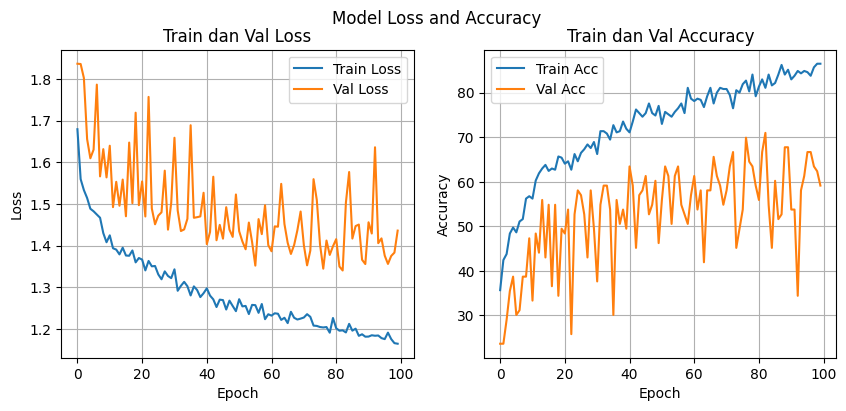

In [ ]:
#bikin plot dari hasil training
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Train dan Val Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accuracies, label='Train Acc')
ax2.plot(val_accuracies, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Train dan Val Accuracy')
ax2.legend()
ax2.grid(True)

fig.suptitle('Model Loss and Accuracy')
plt.show()

In [ ]:
#simpen model
torch.save(model.state_dict(), '/content/drive/MyDrive/model/Ikan_Channa_VGG16_v4')

In [ ]:
#load model
model.load_state_dict(torch.load('/content/drive/MyDrive/model/Ikan_Channa_VGG16_v4'))

<All keys matched successfully>

Saving 3698934098.jpg to 3698934098.jpg
3698934098.jpg
andrao


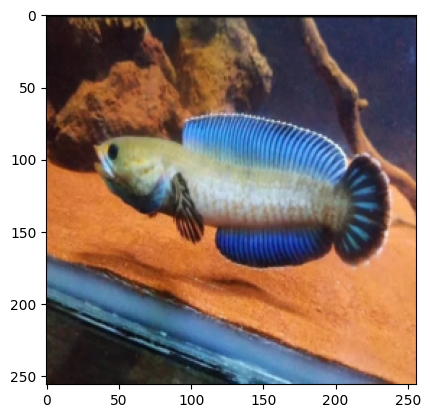

In [ ]:
#pengujian model yg dilatih
uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = torchvision.transforms.functional.resize(
        torchvision.transforms.functional.to_pil_image(
            np.array(Image.open(io.BytesIO(uploaded[fn])))
        ),
        (256, 256)
    )

    imgplot = plt.imshow(img)
    x = torchvision.transforms.functional.to_tensor(img)
    x = x.unsqueeze(0)
    x = x.to(device)
    
    with torch.no_grad():
        outputs = model(x)
    
    _, preds = torch.max(outputs, 1)
    
    print(fn)
    if preds.item() == 0:
        print('andrao')
    elif preds.item() == 1:
        print('asiatica')
    elif preds.item() == 2:
        print('auranti')
    elif preds.item() == 3:
        print('barca')          
    elif preds.item() == 4:
        print('maru')
    elif preds.item() == 5:
        print('stewartii')
    else:
        print('not detected')
